In [9]:
import pandas as pd
import os
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from pingouin import anova
PATH = os.getcwd()

metadata = pd.read_csv(os.path.join(PATH, 'data', 'metadata', 'chip_seq_diff_cell_lines_hypx_3.csv'))


In [2]:
peak_files = glob(os.path.join(PATH, 'data', 'hif1a_chip', 'overlap_peak_cov', '*.depth'))
region_files = glob(os.path.join(PATH, 'data', 'hif1a_chip', 'region_files', '*.csv'))


In [3]:
all_peaks = []
for file in peak_files:
    peaks = pd.read_csv(file, header = None, sep = '\t', names = ['chr','pos','coverage'])
    sample = os.path.split(file)[-1].split('_')[0]
    peaks['sample'] = sample
    peaks['cell_type'] = metadata[metadata['run_accession'] == sample]['cell_type'].values[0]
    peaks['replicate'] = metadata[metadata['run_accession'] == sample]['replicate'].values[0]
    peaks['treatment'] = metadata[metadata['run_accession'] == sample]['treatment'].values[0]
    # Name the peaks for each sample with the sample name and range of positions
    
    all_peaks.append(peaks) 

all_peaks = pd.concat(all_peaks)
all_peaks[['replicate', 'treatment']] = all_peaks[['replicate', 'treatment']].fillna('input')
all_peaks.to_csv(os.path.join(PATH, 'data', 'hif1a_chip', 'all_peaks.csv'), index = False)

all_regions = pd.concat([pd.read_csv(file) for file in region_files])
all_regions['cell_type'] = all_regions['cell_type'].str.upper()
display(all_regions.shape)
all_regions.head()


(1480, 5)

,chr,start,end,cell_type,peak
0,1,629864,630025,A549,1_629864_630025
1,1,633901,634112,A549,1_633901_634112
2,1,31431818,31432160,A549,1_31431818_31432160
3,1,125169994,125170196,A549,1_125169994_125170196
4,1,125174013,125174142,A549,1_125174013_125174142


In [4]:
region_files = glob(os.path.join(PATH, 'data', 'hif1a_chip', 'region_files', '*.bed'))
for file in region_files:
    cur = pd.read_csv(region_files[0], sep = '\t', header = None, names = ['chr','start','end'])
    cur = cur.drop_duplicates(subset = ['start', 'end'])
    cur['cell_type'] = os.path.split(file)[-1].split('_')[0]
    cur['peak'] = cur['chr'] + '_' + cur['start'].astype(str) + '_' + cur['end'].astype(str)
    cur.to_csv(os.path.join(PATH, 'data', 'hif1a_chip', 'region_files', os.path.split(file)[-1].split('_')[0] + '.csv'), sep = ',', index = False, header = True)

In [5]:
# Add the peak name to the peak file
all_peaks['peak'] = ''
for peak in all_regions.iterrows():
    peak = peak[1]
    all_peaks.loc[(all_peaks['chr'] == peak['chr']) & (all_peaks['pos'] >= peak['start']) & (all_peaks['pos'] <= peak['end']) & (all_peaks['cell_type'] == peak['cell_type']), 'peak'] = peak['peak']


In [6]:
all_peaks = pd.read_csv(os.path.join(PATH, 'data', 'hif1a_chip', 'all_peaks_with_regions.csv'))
display(all_peaks.shape)
# drop the mt
all_peaks = all_peaks[all_peaks['chr'] != 'MT']
all_peaks['treatment'] = all_peaks['treatment'].str.replace(' ', '')
all_peaks = all_peaks[all_peaks['peak'].notna()]
# Normalize coverage by reads per million per sample
all_peaks['RPK'] = all_peaks['coverage'] * 1_000 / all_peaks.groupby(['sample'])['coverage'].transform('sum') * 1000000

display(all_peaks.sample(5))
display(all_peaks.shape)


(2086553, 8)

,chr,pos,coverage,sample,cell_type,replicate,treatment,peak,RPK
1893010,KI270466.1,968,206.0,SRR11072733,H460,replicate 2,normoxia,KI270466.1_302_1198,16369.002449
839380,4,49709502,861.0,SRR11072724,RKO,replicate 1,normoxia,4_49709334_49710110,72223.012584
612756,KI270333.1,133,67.0,SRR11072721,HCT116,replicate 2,normoxia,KI270333.1_40_628,5012.677210
298428,KI270733.1,135317,18.0,SRR11072718,A549,input,input,KI270733.1_135047_135456,925.071472
1410293,7,59167636,20.0,SRR11072729,A549,replicate 2,normoxia,7_59167588_59167754,1633.072861


(1446322, 9)

In [7]:
test_peak = all_regions['peak'].sample(1).values[0]
test_peak_df = all_peaks[all_peaks['peak'] == test_peak]

<AxesSubplot:xlabel='peak', ylabel='coverage'>

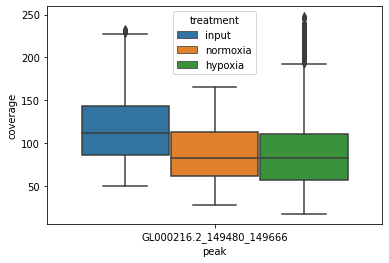

In [8]:
sns.boxplot(data = test_peak_df, x = 'peak', y = 'coverage', hue = 'treatment')


<AxesSubplot:xlabel='peak', ylabel='RPK'>

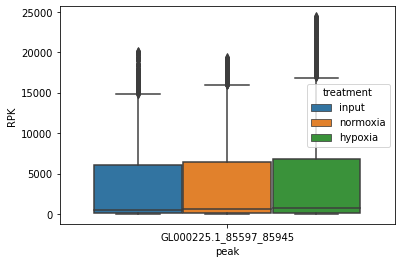

In [187]:
sns.boxplot(data = test_peak_df, x = 'peak', y = 'RPK', hue = 'treatment')


In [188]:
all_regions['p-value'] = 0
all_regions['F'] = 0

for cell in all_regions['cell_type'].unique():
    cell_peaks = all_peaks[all_peaks['cell_type'] == cell]
    for peak in all_regions[all_regions['cell_type'] == cell].peak.unique():
        cur_peaks = cell_peaks[cell_peaks['peak'] == peak][['treatment', 'RPK']]
        if len(cur_peaks['treatment'].unique()) > 2:
            test = anova(data = cur_peaks, dv = 'RPK', between = 'treatment')
            all_regions.loc[(all_regions['peak'] == peak) & (all_regions['cell_type'] == cell), 'p-value'] = test['p-unc'][0]
            all_regions.loc[(all_regions['peak'] == peak) & (all_regions['cell_type'] == cell), 'F'] = test['F'][0]




c:\Users\noam1\AppData\Local\Programs\Python\Python39\lib\site-packages\pingouin\parametric.py:972: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sserror = grp.apply(lambda x: (x - x.mean())**2).sum()
c:\Users\noam1\AppData\Local\Programs\Python\Python39\lib\site-packages\pingouin\parametric.py:972: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this wa

In [189]:
# Perform a bonferroni correction for multiple testing
all_regions['q-value'] = all_regions['p-value'] * len(all_regions['peak'].unique())
all_regions['q-value'] = all_regions['q-value'].apply(lambda x: 1 if x > 1 else x)
all_regions['significant'] = all_regions['q-value'] < 0.05


In [193]:
insig_regions = all_regions[all_regions['significant'] == False]
for cell in insig_regions.cell_type.unique():
    insig_regions = insig_regions.append({'chr': 'MT', 'start': 1, 'end': 16569, 'cell_type': cell, 'peak': 'MT_1_16569', 'p-value': 1, 'F': 0, 'q-value': 1, 'significant': True}, ignore_index = True)
    insig_regions.loc[insig_regions['cell_type'] == cell ,['chr', 'start', 'end']].to_csv(os.path.join(PATH, 'data', 'hif1a_chip', f'insig_regions_{cell}.bed'), index = False, header = False, sep = '\t')

C:\Users\noam1\AppData\Local\Temp/ipykernel_15080/2943312323.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  insig_regions = insig_regions.append({'chr': 'MT', 'start': 1, 'end': 16569, 'cell_type': cell, 'peak': 'MT_1_16569', 'p-value': 1, 'F': 0, 'q-value': 1, 'significant': True}, ignore_index = True)
C:\Users\noam1\AppData\Local\Temp/ipykernel_15080/2943312323.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  insig_regions = insig_regions.append({'chr': 'MT', 'start': 1, 'end': 16569, 'cell_type': cell, 'peak': 'MT_1_16569', 'p-value': 1, 'F': 0, 'q-value': 1, 'significant': True}, ignore_index = True)
C:\Users\noam1\AppData\Local\Temp/ipykernel_15080/2943312323.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  